In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

In [64]:
# Caminhos dos arquivos
file_2023_path = "Dados/Regional Tapirus out23-mar24.xlsx"
file_2024_path = "Dados/Regional Tapirus out24-mar25.xlsx"

# Carregar os dados dos arquivos Excel
df_2023 = pd.read_excel(file_2023_path)
df_2024 = pd.read_excel(file_2024_path)

c:\Users\matheus.rezende\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\matheus.rezende\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [65]:
def gerar_grafico_precipitacao_decendio(df, titulo, cor_barra='skyblue', cor_linha='red', mostrar=True):
    """
    Gera um gráfico de precipitação por decêndio (10 dias) com barras verticais
    e uma linha representando o acumulado mensal.
    
    Parâmetros:
    df (DataFrame): DataFrame contendo os dados de precipitação
    titulo (str): Título do gráfico
    cor_barra (str): Cor das barras de precipitação por decêndio
    cor_linha (str): Cor da linha de acumulado mensal
    mostrar (bool): Se True, exibe o gráfico imediatamente
    
    Retorna:
    fig: Objeto figura do matplotlib
    """
    # Converter a coluna de datas
    df["data"] = pd.to_datetime(df["início do periodo [GMT-3]"], dayfirst=True)
    
    # Adicionar colunas auxiliares
    df["ano_mes"] = df["data"].dt.to_period("M").astype(str)
    df["mes"] = df["data"].dt.month
    df["mes_nome"] = df["data"].dt.month_name()
    df["dia"] = df["data"].dt.day
    
    # Definir decêndio (1-10, 11-20, 21-último dia do mês)
    df["decêndio"] = pd.cut(df["dia"], bins=[0, 10, 20, 31], labels=["1", "2", "3"])
    
    # Criar identificador único para cada decêndio
    df["ano_mes_dec"] = df["ano_mes"] + " - D" + df["decêndio"].astype(str)
    
    # Calcular precipitação total por decêndio
    decendio_sum = df.groupby("ano_mes_dec")["precipitação [mm]"].sum().reset_index()
    
    # Calcular precipitação acumulada por mês
    mensal_acumulado = df.groupby("ano_mes")["precipitação [mm]"].sum().reset_index()
    
    # Preparar dados para o gráfico
    # Criar um DataFrame combinado para facilitar o plot
    plot_data = []
    
    for mes in sorted(df["ano_mes"].unique()):
        mes_acumulado = mensal_acumulado[mensal_acumulado["ano_mes"] == mes]["precipitação [mm]"].values[0]
        
        for dec in ["1", "2", "3"]:
            dec_id = f"{mes} - D{dec}"
            dec_value = decendio_sum[decendio_sum["ano_mes_dec"] == dec_id]["precipitação [mm]"].values[0] if dec_id in decendio_sum["ano_mes_dec"].values else 0
            
            # Extrair mês e ano para rótulos mais limpos
            mes_data = pd.to_datetime(mes + "-01")
            mes_nome = mes_data.strftime("%b/%Y")
            
            plot_data.append({
                "ano_mes": mes,
                "mes_nome": mes_nome,
                "decêndio": dec,
                "decêndio_label": f"{mes_nome}\nD{dec}",
                "precipitacao_decêndio": dec_value,
                "precipitacao_acumulada": mes_acumulado
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Criar o gráfico
    fig, ax1 = plt.subplots(figsize=(16, 8))
    
    # Barras para precipitação por decêndio
    sns.barplot(
        x="decêndio_label", 
        y="precipitacao_decêndio", 
        data=plot_df, 
        color=cor_barra, 
        ax=ax1,
        label="Precipitação por Decêndio"
    )
    
    # Adicionar valores nas barras
    for i, p in enumerate(ax1.patches):
        height = p.get_height()
        if height > 0:  # Só mostrar valores > 0
            ax1.annotate(
                f'{height:.1f}', 
                (p.get_x() + p.get_width() / 2., height + 2),
                ha='center', va='bottom',
                fontsize=9
            )
    
    # Configurar eixo primário (barras)
    ax1.set_ylabel("Precipitação por Decêndio (mm)", fontsize=12)
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    
    # Criar eixo secundário para a linha de acumulado
    ax2 = ax1.twinx()
    
    # Linha para precipitação acumulada mensal
    # Agrupar por mês para desenhar a linha corretamente
    monthly_data = plot_df.drop_duplicates(subset=["ano_mes"])
    
    # Desenhar linha de acumulado
    line = ax2.plot(
        range(0, len(plot_df), 3),  # Posicionar a linha nos meses (a cada 3 decêndios)
        monthly_data["precipitacao_acumulada"],
        color=cor_linha, 
        marker='o', 
        linewidth=2,
        label="Acumulado Mensal"
    )
    
    # Adicionar valores na linha
    for i, (x, y) in enumerate(zip(range(0, len(plot_df), 3), monthly_data["precipitacao_acumulada"])):
        ax2.annotate(
            f'{y:.1f}', 
            (x, y + 5),
            ha='center', 
            va='bottom',
            color=cor_linha,
            fontsize=10,
            fontweight='bold'
        )
    
    # Configurar eixo secundário (linha)
    ax2.set_ylabel("Precipitação Acumulada Mensal (mm)", fontsize=12)
    ax2.tick_params(axis='y', labelcolor=cor_linha)
    
    # Adicionar título e legenda
    plt.title(titulo, fontsize=14, fontweight='bold', pad=20)
    
    # Combinar legendas dos dois eixos
    bars, _ = ax1.get_legend_handles_labels()
    lines, _ = ax2.get_legend_handles_labels()
    ax1.legend(bars + lines, ["Precipitação por Decêndio", "Acumulado Mensal"], 
              loc='upper left', fontsize=10)
    
    # Ajustar layout
    plt.tight_layout()
    
    # Mostrar o gráfico se solicitado
    if mostrar:
        plt.show()
    
    return fig

def gerar_graficos_safras(df_2023, df_2024, mostrar=True):
    """
    Gera dois gráficos de precipitação por decêndio, um para cada safra.
    
    Parâmetros:
    df_2023 (DataFrame): DataFrame contendo os dados da safra 2023-2024
    df_2024 (DataFrame): DataFrame contendo os dados da safra 2024-2025
    mostrar (bool): Se True, exibe os gráficos imediatamente
    
    Retorna:
    tuple: (fig_2023, fig_2024) - Objetos figura do matplotlib para cada safra
    """
    # Gerar gráfico para safra 2023-2024
    fig_2023 = gerar_grafico_precipitacao_decendio(
        df_2023, 
        "Precipitação por Decêndio - Safra 2023/2024",
        cor_barra='#4682B4',  # Steel Blue
        cor_linha='#B22222',  # Firebrick
        mostrar=mostrar
    )
    
    # Gerar gráfico para safra 2024-2025
    fig_2024 = gerar_grafico_precipitacao_decendio(
        df_2024, 
        "Precipitação por Decêndio - Safra 2024/2025",
        cor_barra='#20B2AA',  # Light Sea Green
        cor_linha='#8B0000',  # Dark Red
        mostrar=mostrar
    )
    
    return fig_2023, fig_2024

# Exemplo de uso (não será executado se importado como módulo)
if __name__ == "__main__":
    print("Este arquivo contém funções para gerar gráficos de precipitação por decêndio.")
    print("Importe-o em seu notebook para utilizar as funções.")

Este arquivo contém funções para gerar gráficos de precipitação por decêndio.
Importe-o em seu notebook para utilizar as funções.


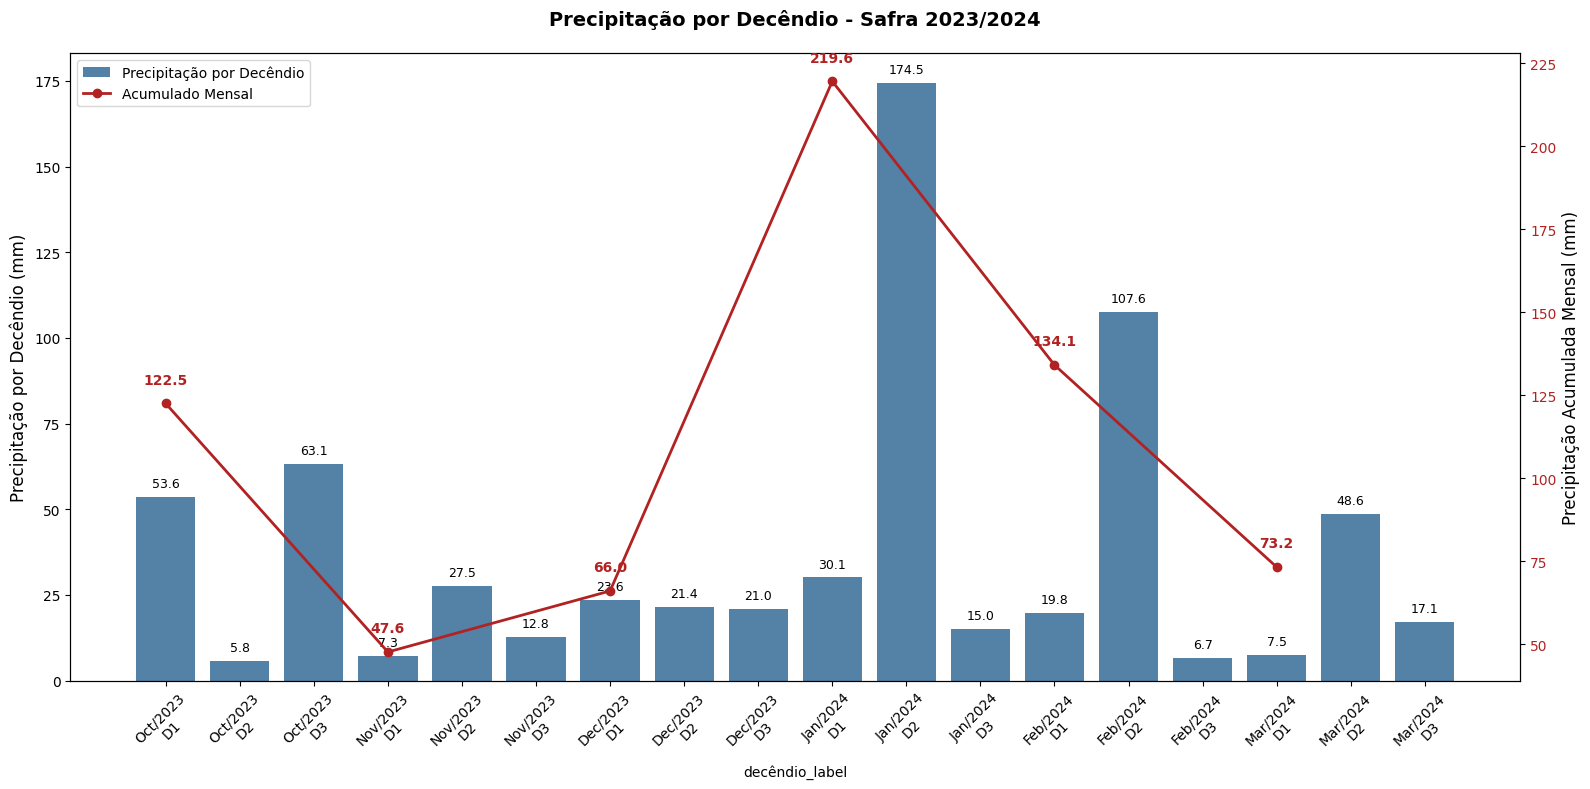

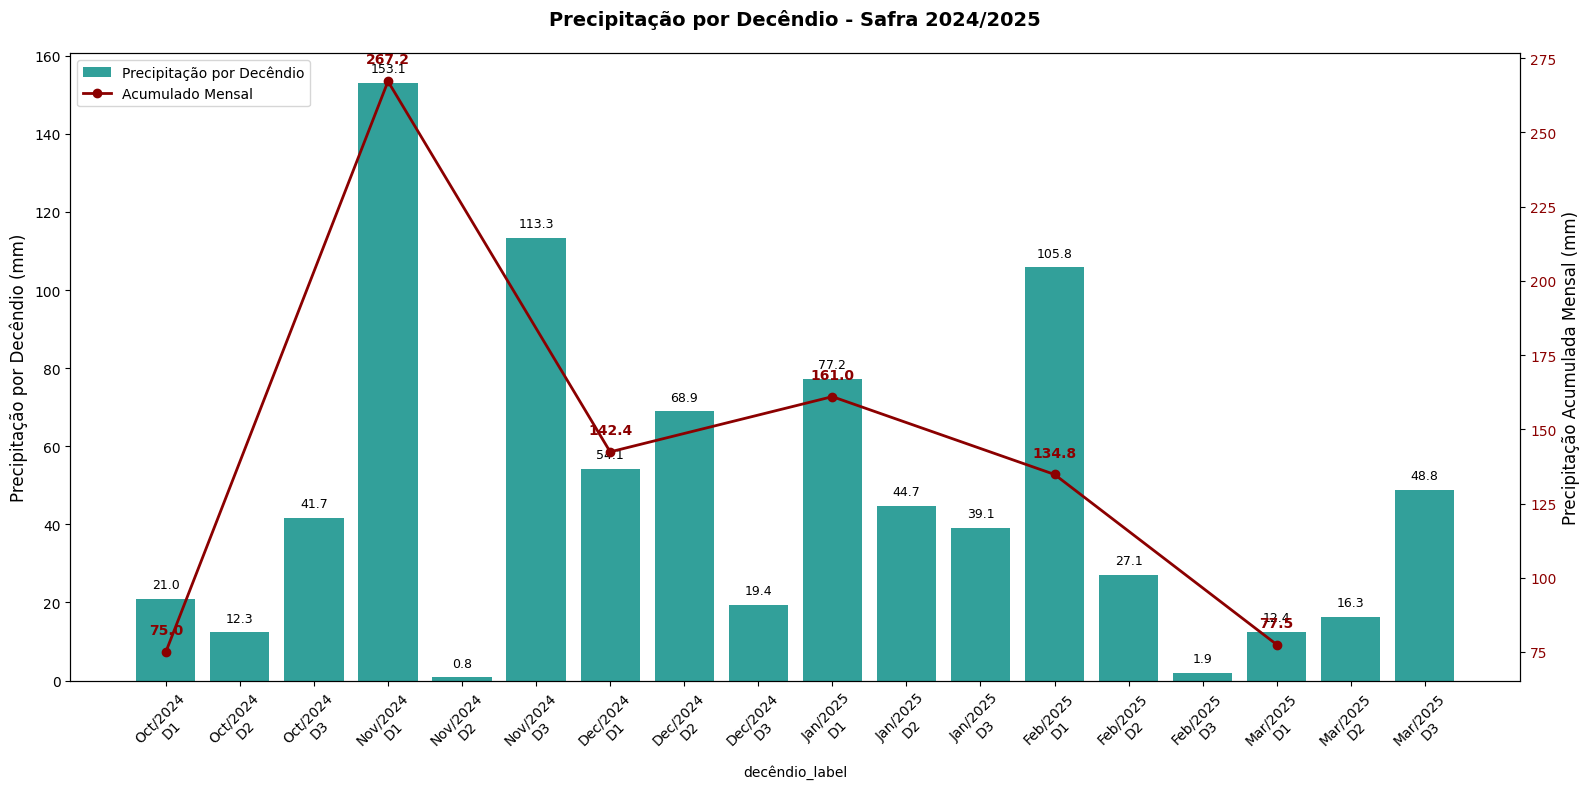

In [67]:
# Gerar os dois gráficos separados para cada safra
fig_2023, fig_2024 = gerar_graficos_safras(df_2023, df_2024)

# Para análise adicional, você pode verificar os valores de precipitação por decêndio
# Converter a coluna de datas e criar colunas auxiliares para ambos os DataFrames
for df, nome in [(df_2023, "2023-2024"), (df_2024, "2024-2025")]:
    df["data"] = pd.to_datetime(df["início do periodo [GMT-3]"], dayfirst=True)
    df["ano_mes"] = df["data"].dt.to_period("M").astype(str)
    df["mes_nome"] = df["data"].dt.month_name()
    df["dia"] = df["data"].dt.day
    df["decêndio"] = pd.cut(df["dia"], bins=[0, 10, 20, 31], labels=["1", "2", "3"])
    df["ano_mes_dec"] = df["ano_mes"] + " - D" + df["decêndio"].astype(str)